# Artificial Neural Network

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                             roc_auc_score, log_loss, matthews_corrcoef, balanced_accuracy_score, 
                             cohen_kappa_score, confusion_matrix)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [55]:
df = pd.read_csv('dataset.csv')

C:\Users\raksh\AppData\Local\Temp\ipykernel_12064\112859877.py:1: DtypeWarning: Columns (22,25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('dataset.csv')


- Data Quality (Missing Values): We favor features with a reasonably high percentage of valid data (generally, those with at least about 50% non‐missing values) so that imputation is feasible.
- Domain Relevance: We keep features that are likely to carry useful information about the engine’s status (e.g., sensor readings, diagnostic codes) and drop those that are either redundant (or merely identifiers) or have no predictive value.

In [58]:
def get_engine_status(row):
    dtc = str(row['DTC_NUMBER']).strip() if pd.notnull(row['DTC_NUMBER']) else ""
    tc = str(row['TROUBLE_CODES']).strip() if pd.notnull(row['TROUBLE_CODES']) else ""
    # Rule:
    # If DTC_NUMBER equals "MIL is OFF1" OR Trouble_codes is nonblank and starts with "P", then malfunctioning.
    if dtc == "MIL is OFF1" or (tc != "" and tc.upper().startswith("P")):
        return 1  # malfunctioning
    else:
        return 0  # healthy

In [59]:
cols_to_drop = [
    'AUTOMATIC', 'BAROMETRIC_PRESSURE(KPA)', 'FUEL_LEVEL', 'AMBIENT_AIR_TEMP', 
    'INTAKE_MANIFOLD_PRESSURE', 'MAF', 'LONG TERM FUEL TRIM BANK 2', 'FUEL_TYPE', 
    'FUEL_PRESSURE', 'SHORT TERM FUEL TRIM BANK 2', 'ENGINE_RUNTIME', 
    'EQUIV_RATIO', 'TIMESTAMP', 'VEHICLE_ID'
]
df.drop(columns=cols_to_drop, errors='ignore', inplace=True)

#### Feature Selection

In [60]:
feature_cols = [
    'MARK', 'MODEL', 'CAR_YEAR', 'ENGINE_POWER', 'ENGINE_COOLANT_TEMP', 
    'ENGINE_LOAD', 'ENGINE_RPM', 'AIR_INTAKE_TEMP', 'SPEED', 
    'SHORT TERM FUEL TRIM BANK 1', 'THROTTLE_POS', 'TIMING_ADVANCE', 
    'MIN', 'HOURS', 'DAYS_OF_WEEK', 'MONTHS', 'YEAR'
]
df_model = df[ feature_cols + ['DTC_NUMBER', 'TROUBLE_CODES'] ].copy()
df_model['EngineStatus'] = df_model.apply(get_engine_status, axis=1)
df_model.dropna(subset=['EngineStatus'], inplace=True)

In [61]:
#Split Data into Features and Target
X = df_model[feature_cols]
y = df_model['EngineStatus']
meta_info = df_model[['DTC_NUMBER', 'TROUBLE_CODES']]

In [62]:
categorical_features = ['MARK', 'MODEL']
numeric_features = [col for col in feature_cols if col not in categorical_features]
# Pipeline for numeric features: impute missing values with median and scale.
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Pipeline for categorical features: impute missing values with most frequent and one-hot encode.
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)


In [63]:
# split data into training and testing sets
X_train, X_test, y_train, y_test, meta_train, meta_test = train_test_split(
    X, y, meta_info, test_size=0.2, random_state=42
)
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

## Model of ANN

In [64]:
input_dim = X_train_processed.shape[1]  # number of features after preprocessing
model_ann = Sequential([
    Dense(64, input_dim=input_dim, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification output
])
model_ann.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

c:\Users\raksh\anaconda3\envs\unet_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Train the model

In [65]:
# Train the model
# Use early stopping to prevent overfitting.
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history_ann = model_ann.fit(
    X_train_processed, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop]
)



Epoch 1/10
951/951 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9541 - loss: 0.1287 - val_accuracy: 0.9934 - val_loss: 0.0169
Epoch 2/10
951/951 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9955 - loss: 0.0151 - val_accuracy: 0.9957 - val_loss: 0.0146
Epoch 3/10
951/951 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9953 - loss: 0.0150 - val_accuracy: 0.9958 - val_loss: 0.0144
Epoch 4/10
951/951 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9964 - loss: 0.0125 - val_accuracy: 0.9959 - val_loss: 0.0143
Epoch 5/10
951/951 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9963 - loss: 0.0119 - val_accuracy: 0.9958 - val_loss: 0.0144
Epoch 6/10
951/951 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9954 - loss: 0.0134 - val_accuracy: 0.9958 - val_loss: 0.0158
Epoch 7/10
951/951 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9954 - loss: 0.0141 - val_accuracy: 0.9959 - val_loss: 0.0139
Epoch 8/10
951/951 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9954 - loss: 0.0132 - val_accuracy: 0.

### Evaluation of the model

297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9961 - loss: 0.0139
ANN Test Loss: 0.0144, ANN Test Accuracy: 0.9964
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


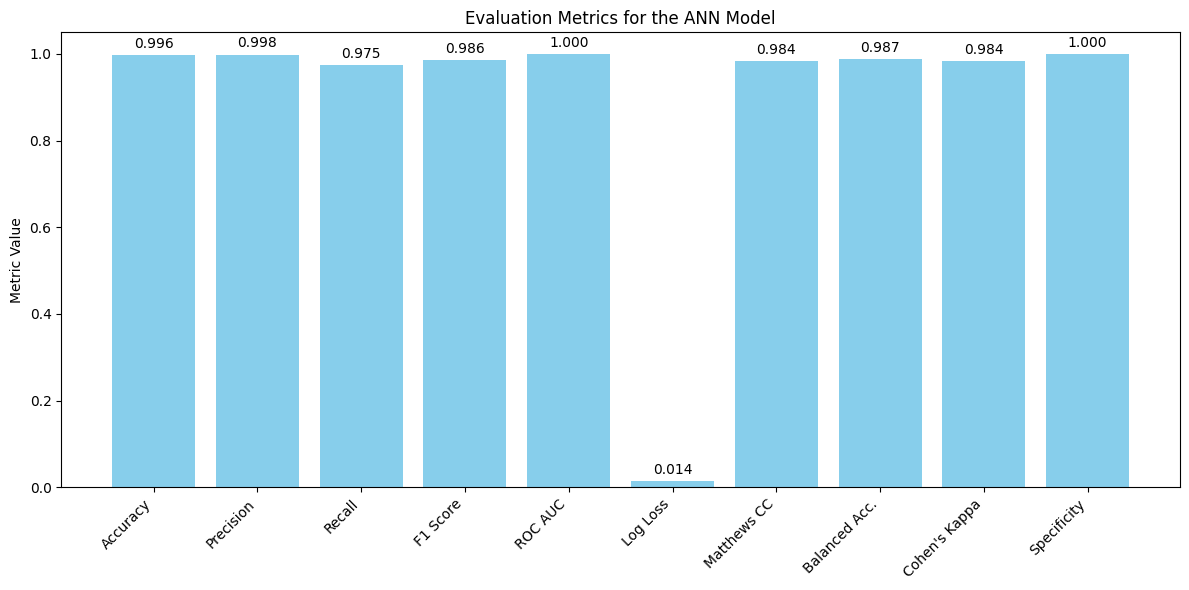

Sample 15805: Prediction: No malfunctioning
Sample 33942: Prediction: No malfunctioning
Sample 14577: Prediction: No malfunctioning
Sample 6113: Prediction: No malfunctioning
Sample 28348: Prediction: No malfunctioning
Sample 15039: Prediction: No malfunctioning
Sample 40224: Prediction: No malfunctioning
Sample 13197: Prediction: No malfunctioning
Sample 39394: Prediction: No malfunctioning
Sample 13988: Prediction: No malfunctioning
Sample 37140: Prediction: No malfunctioning
Sample 32396: Prediction: No malfunctioning
Sample 31374: Prediction: No malfunctioning
Sample 5692: Prediction: No malfunctioning
Sample 43455: Prediction: No malfunctioning
Sample 8761: Prediction: No malfunctioning
Sample 32445: Prediction: No malfunctioning
Sample 41419: Prediction: No malfunctioning
Sample 40145: Prediction: No malfunctioning
Sample 20831: DTC_NUMBER: MIL is OFF1 codes, Trouble_codes: P0133 -> Prediction: Malfunctioning
Sample 30899: Prediction: No malfunctioning
Sample 21109: DTC_NUMBER: M

In [66]:
test_loss_ann, test_accuracy_ann = model_ann.evaluate(X_test_processed, y_test)
print(f'ANN Test Loss: {test_loss_ann:.4f}, ANN Test Accuracy: {test_accuracy_ann:.4f}')
y_pred_proba_ann = model_ann.predict(X_test_processed)
y_pred_ann = (y_pred_proba_ann >= 0.5).astype(int).flatten()
acc = accuracy_score(y_test, y_pred_ann)
prec = precision_score(y_test, y_pred_ann)
rec = recall_score(y_test, y_pred_ann)
f1 = f1_score(y_test, y_pred_ann)
roc_auc = roc_auc_score(y_test, y_pred_proba_ann)
ll = log_loss(y_test, y_pred_proba_ann)
mcc = matthews_corrcoef(y_test, y_pred_ann)
bal_acc = balanced_accuracy_score(y_test, y_pred_ann)
kappa = cohen_kappa_score(y_test, y_pred_ann)
cm = confusion_matrix(y_test, y_pred_ann)
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

metrics_dict_ann = {
    "Accuracy": acc,
    "Precision": prec,
    "Recall": rec,
    "F1 Score": f1,
    "ROC AUC": roc_auc,
    "Log Loss": ll,
    "Matthews CC": mcc,
    "Balanced Acc.": bal_acc,
    "Cohen's Kappa": kappa,
    "Specificity": specificity
}

plt.figure(figsize=(12, 6))
bars = plt.bar(metrics_dict_ann.keys(), metrics_dict_ann.values(), color='skyblue')
plt.title("Evaluation Metrics for the ANN Model")
plt.ylabel("Metric Value")
plt.xticks(rotation=45, ha="right")
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width()/2, height),
                 xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')
plt.tight_layout()
plt.show()

predictions_df = meta_test.copy()
predictions_df['Predicted_Status'] = y_pred_ann
predictions_df['Prediction'] = predictions_df['Predicted_Status'].apply(
    lambda x: "Malfunctioning" if x == 1 else "No malfunctioning"
)

# Print the predictions.
for idx, row in predictions_df.iterrows():
    if row['Predicted_Status'] == 1:
        print(f"Sample {idx}: DTC_NUMBER: {row['DTC_NUMBER']}, Trouble_codes: {row['TROUBLE_CODES']} -> Prediction: Malfunctioning")
    else:
        print(f"Sample {idx}: Prediction: No malfunctioning")